In [2]:
from network_analysis.geodf_network import GeoDataNetwork
import geopandas as gpd
from pathlib import Path
from geoprocessing.faf_zone_network import link_weights
import networkx as nx
import pandas as pd
import numpy as np

import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = Path.cwd().parent

In [3]:
ntad_nodes = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
ntad_links = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")

In [4]:
ntad_nodes = ntad_nodes.set_index('FRANODEID', drop=False)

In [58]:
faf_network_dir = BASE_DIR / 'resources/shapefiles/faf_network_exploded'

faf_links = gpd.GeoDataFrame.from_file(faf_network_dir / 'faf_links.shp')
faf_nodes = gpd.GeoDataFrame.from_file(faf_network_dir / 'faf_nodes.shp')
faf_nodes.FAF_Zone = faf_nodes.FAF_Zone.astype(int)
faf_nodes = faf_nodes.set_index('FAF_Zone')

In [59]:
faf_org_network_dir = BASE_DIR / 'resources/shapefiles/faf_network'

faf_org_links = gpd.GeoDataFrame.from_file(faf_org_network_dir / 'faf_links.shp')
faf_org_nodes = gpd.GeoDataFrame.from_file(faf_org_network_dir / 'faf_nodes.shp')
faf_org_nodes.FAF_Zone = faf_org_nodes.FAF_Zone.astype(int)
faf_org_nodes = faf_org_nodes.set_index('FAF_Zone')

In [48]:
faf_links

,FAF_Zone_f,FAF_Zone_t,BRANCH,CNTYFIPS,COUNTRY,DIVISION,FRAARCID,FRADISTRCT,FRFRANODE,KM,...,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,YARDNAME,geometry
0,11,19,17,19,19,17,19,19,19,19,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-86.76365 33.47538, -86.78008 33.0..."
1,12,19,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-88.06251 30.72613, -86.78008 33.0..."
2,12,280,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-88.06251 30.72613, -89.48377 32.5..."
3,12,4129,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-88.06251 30.72613, -84.7611 30.22..."
4,19,131,3,4,4,3,4,4,4,4,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-86.78008 33.0568, -84.37138 33.80..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,531,539,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-122.37721 47.46371, -119.26865 47..."
271,532,539,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-122.76488 45.88636, -119.26865 47..."
272,540,2399,6,7,7,6,7,7,7,7,...,1,0,0,0,0,0,0,0,0,"LINESTRING (-81.02183 38.58522, -81.5012 40.06..."
273,551,559,15,15,15,15,15,15,15,15,...,0,0,0,0,0,0,0,0,0,"LINESTRING (-88.19888 43.0759, -89.63998 44.41..."


In [70]:
agg_network_dir = BASE_DIR / 'resources/shapefiles/agg_network'
agg_links = gpd.GeoDataFrame.from_file(agg_network_dir / 'agg_links.shp')
agg_nodes = gpd.GeoDataFrame.from_file(agg_network_dir / 'agg_nodes.shp')
agg_nodes = agg_nodes.set_index('Node', drop=True)

In [7]:
ntad_geonet = GeoDataNetwork(ntad_nodes,ntad_links,'FRANODEID', lambda df : 0, lambda df : df[['FRFRANODE', 'TOFRANODE']])
ntad_railnet = ntad_geonet.createNetwork(NAME='NTAD')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


In [8]:
for e in ntad_railnet.edges:
  print(ntad_railnet.nodes[e[1]])
  print(ntad_railnet.degree[e[1]])
  break

{'id': 300003, 'label': 300003, 'y': 20.881019629865722, 'x': -156.67863348557364}
2


In [60]:
faf_geonet = GeoDataNetwork(faf_nodes,faf_links,'FAF_Zone_1', lambda df : 0, lambda df : df[['FAF_Zone_f', 'FAF_Zone_t']])
faf_railnet = faf_geonet.createNetwork(NAME='FAF')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


In [61]:
faf_org_geonet = GeoDataNetwork(faf_org_nodes,faf_org_links,'FAF_Zone_1', lambda df : 0, lambda df : df[['FAF_Zone_f', 'FAF_Zone_t']])
faf_org_railnet = faf_org_geonet.createNetwork(NAME='FAF')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


In [62]:
agg_geonet = GeoDataNetwork(agg_nodes,agg_links,'Node', lambda df : 0, lambda df : df[['Node_fr', 'Node_to']])
agg_railnet = agg_geonet.createNetwork(NAME='Aggregate')

/home/nathanczh/ctsm/faf_flow_assignment/src/network_analysis/geodf_network.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linksDf['weight'] = self.network_weight_fn(self.edgeDf)


,NTAD,FAF,Aggregate
Node Count,250436,139,100
Link Count,289309,275,226
Network Density,0.000009,0.028673,0.045657
Node Degrees,"{300000: 2, 300001: 1, 300002: 1, 300003: 2, 3...","{11: 1, 12: 3, 19: 8, 41: 2, 42: 2, 49: 5, 50:...","{1: 4, 2: 4, 3: 3, 4: 3, 5: 5, 6: 3, 7: 3, 8: ..."
Mean Node Degree,2.310443,3.956835,4.52
Std Dev Node Degree,0.836978,2.288132,1.590472
Clustering,0.04333,0.444682,0.395865
Characteristic Path Length,NaN,5.747472,5.116566
Mean Connectivity,NaN,2.180794,3.310505
Betweenness Centrality,NaN,"{11: 0.0, 12: 0.0053566409190983506, 19: 13.55...","{1: 0.34387419195471747, 2: 0.0152987578371572..."


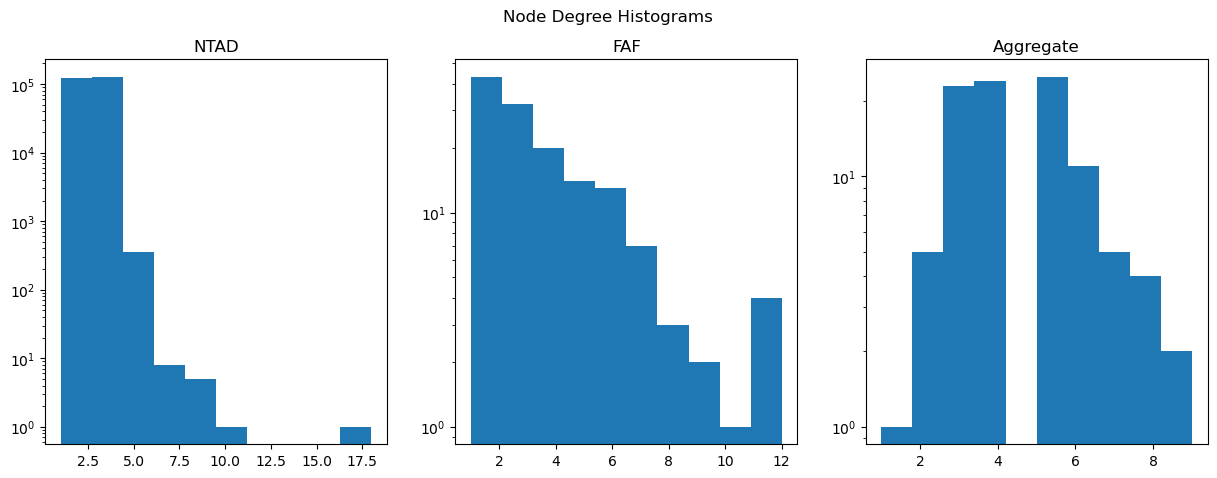

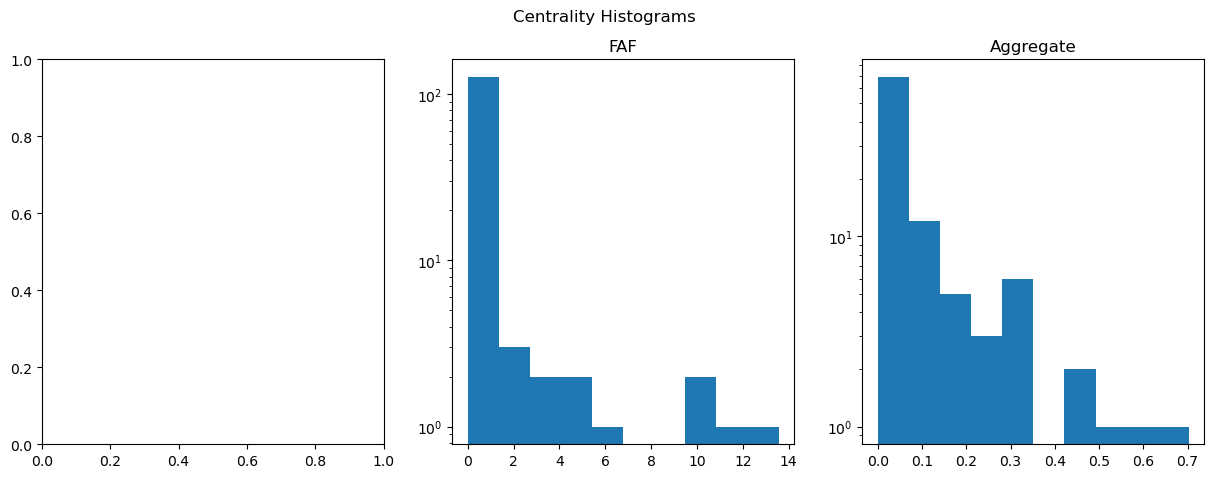

In [73]:
stats = []
import matplotlib.pyplot as plt

deg_fig, deg_axes = plt.subplots(1,3, figsize=(15,5))
deg_fig.suptitle('Node Degree Histograms')

conn_fig, conn_axes = plt.subplots(1,3, figsize=(15,5))
conn_fig.suptitle('Centrality Histograms')

# conn_axes[0].hist(usages, log=True)

i = 0
for name, net, geonet in (
  ('NTAD', ntad_railnet, ntad_geonet),
  ('FAF', faf_railnet, faf_geonet),
  # ('FAF Org', faf_org_railnet, faf_org_geonet),
  ('Aggregate', agg_railnet, agg_geonet)
):
  stat = {}
  stat['Node Count'] =  len(net.nodes)
  stat['Link Count'] =  len(net.edges)
  stat['Network Density'] = nx.density(net)
  stat['Node Degrees'] = dict(net.degree(net.nodes))
  node_degree_arr = np.array(list(stat['Node Degrees'].values()))
  stat['Mean Node Degree'] = node_degree_arr.mean()
  stat['Std Dev Node Degree'] = node_degree_arr.std()
  deg_axes[i].hist(list(stat['Node Degrees'].values()), log=True)
  deg_axes[i].set_title(name)

  if name != 'NTAD':
    largest_cc = max(nx.connected_components(net), key=len)
    stat['Characteristic Path Length'] = nx.average_shortest_path_length(net.subgraph(largest_cc).copy())
    stat['Mean Connectivity'] = nx.average_node_connectivity(net)
    stat['Betweenness Centrality'] = nx.betweenness_centrality(net, weight='weight')
    stat['Mean Betweenness Centrality'] = np.array(list(stat['Betweenness Centrality'].values())).mean()
    # display(stat['Connectivity'].values())
    # break
    conn_axes[i].hist(list(stat['Betweenness Centrality'].values()), log=True)
    conn_axes[i].set_title(name)

  stat['Clustering'] = nx.average_clustering(net)
  
  # stat['Centrality'] = nx.degree_centrality(net)

  i += 1
  
  stats.append(stat)
  
stats_df = pd.DataFrame(stats, index=['NTAD', 'FAF', 'Aggregate']).T
stats_df

# plt.show()
# bcDf = pd.DataFrame([stats_df.loc['Connectivity', 'Aggregate'].values(), stats_df.loc['Connectivity', 'Aggregate'].keys()], index=['vals', 'keys']).T.sort_values('vals', ascending=False).reset_index()#.rename(columns={'index':''}).reset_index(drop=False)
# display(bcDf)

In [64]:
43.9*3

131.7

In [ ]:
import time

def EcNLPathTree(A, wn_PoDHa_data, Links, LINK_WEIGHT='PhysicalLe'):
    start = time.time()
    # Create a graph from the adjacency matrix
    GG = nx.Graph(A)
    n = GG.number_of_nodes()
    Connectedness = np.zeros((n, n))

    # Iterate through each pair of nodes
    for i in range(n):
        for j in range(i + 1, n):
            try:
                # Find all shortest paths between nodes i and j
                paths = list(nx.all_shortest_paths(GG, source=i, target=j, weight='weight'))
                total_connectedness = 0

                # Calculate connectedness for each shortest path
                for path_nodes in paths:
                    # Create edges from the path
                    path_edges = [(path_nodes[k], path_nodes[k + 1]) for k in range(len(path_nodes) - 1)]
                    # Sort each edge individually
                    path_edges_sorted = [tuple(sorted(edge)) for edge in path_edges]

                    e = np.isin(Links.iloc[:, :2].values, path_edges_sorted).all(axis=1)
                    f = np.sum(Links.loc[e, LINK_WEIGHT])
                    fn = np.sum(wn_PoDHa_data[path_nodes[:-1]])

                    # Calculate connectedness contribution of this path
                    total_connectedness += (f + fn) / ((len(path_nodes) * 2 - 1) * (len(path_nodes) - 1))

                # Average the connectedness over all shortest paths for this pair
                Connectedness[i, j] = total_connectedness / len(paths)

            except nx.NetworkXNoPath:
                # If there are no paths, set connectedness to 0
                Connectedness[i, j] = 0

    # Sum the connectedness values and compute the final result
    E_c = np.sum(Connectedness) * 2 / (n * (n - 1)) if n > 1 else 0  # Handle case where n <= 1
    end = time.time()
    length = end - start
    print("Time taken: ", length)
    return E_c

def connectivity(nodes_df, links_df, FR='Node_fr', TO='Node_to', NODE_WEIGHT='PopuWeight', LINK_WEIGHT='Physical L'):
  node_weights = nodes_df[NODE_WEIGHT].copy()
  Links = links_df[[FR, TO, LINK_WEIGHT]]
  link_nodes = links_df[[FR, TO]]
  used_nodes = set(links_df[FR]).union(set(links_df[TO]))
  unique_nodes = np.unique(link_nodes)
  n = len(unique_nodes)

  # Create graphs using networkx
  G = nx.Graph()
  Gw = nx.Graph()
  # Adding nodes first (from both start and end nodes)
  
  G.add_nodes_from(used_nodes)
  Gw.add_nodes_from(used_nodes)
  # Adding edges to the graph
  G.add_edges_from([(links_df[FR][i], links_df[TO][i]) for i in range(len(links_df))])
  Gw.add_weighted_edges_from([(links_df[FR][i], links_df[TO][i], links_df[LINK_WEIGHT][i]) for i in range(len(links_df))])

  # Calculate the adjacency matrix of Gw
  A = nx.to_numpy_array(Gw, weight='weight')

  # Compute the connectedness efficiency using EcNLPathTree function
  Connectedness_efficiency = EcNLPathTree(A, node_weights, links_df, LINK_WEIGHT=LINK_WEIGHT)
  print(f'Connectedness Efficiency: {Connectedness_efficiency}')

  # Compute Efficiency Impact on nodes
  indices = unique_nodes
  EfficiencyImpact_n = np.zeros(len(indices))

  for idx, i in enumerate(indices):
    A1 = A.copy()
    A1[i, :] = 0
    A1[:, i] = 0
    Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
    EfficiencyImpact_n[idx] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
    print(f'{idx + 1}: {Connectedness_efficiency_new}')
  # Compute Efficiency Impact on links
  EfficiencyImpact_l = np.zeros(len(Links))

  # Convert the results to pandas DataFrames
  node_efficiency_impact_df = pd.DataFrame({
      'Node': list(range(len(EfficiencyImpact_n))),  # Node indices
      'Efficiency Impact': EfficiencyImpact_n
  })

  for i in range(len(Links)):
      A1 = A.copy()
      A1[link_nodes[FR][i], link_nodes[TO][i]]= 0
      A1[link_nodes[TO][i], link_nodes[FR][i]] = 0
      Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
      EfficiencyImpact_l[i] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
      print(f'{i + 1}')

  link_efficiency_impact_df = pd.DataFrame({
      'Link (from, to)': list(link_nodes.iloc[:, :2].values),  # Links as tuples of (from, to)
      'Efficiency Impact': EfficiencyImpact_l
  })

  return node_efficiency_impact_df, link_efficiency_impact_df

connectivity(agg_nodes, agg_links)

In [ ]:
def EcNLPathTree(A, wn_PoDHa_data, Links, FR, TO, LINK_WEIGHT):
  GG = A
  start = time.time()
  # Create a graph from the adjacency matrix
  # GG = nx.Graph(A)
  n = GG.number_of_nodes()
  Connectedness = 0
  Links = Links.set_index([FR, TO])
  # display(Links.loc[(3,6), :])

  # Iterate through each pair of nodes

  for i in GG.nodes:
    for j in GG.nodes:
      if i >= j:
        continue
      try:
        paths = list(nx.all_shortest_paths(GG, source=i, target=j, weight='weight'))
  # all_paths = list(nx.all_pairs_all_shortest_paths(GG, weight='weight'))
  # for i, j_paths in all_paths:
  #   for j in j_paths:
  #     if i == j:
  #        continue
  #     try:
  #         paths = j_paths[j]
        total_connectedness = 0

        # Calculate connectedness for each shortest path
        for path_nodes in paths:
          path_edges = [(path_nodes[k], path_nodes[k + 1]) for k in range(len(path_nodes) - 1)]
          # Sort each edge individually
          path_edges_sorted = [(edge[1],edge[0])  if edge[1] < edge[0] else edge for edge in path_edges]
          print(path_edges_sorted)
          # e = np.isin(link_list, path_edges_sorted).all(axis=1)
          f = np.sum(Links.loc[path_edges_sorted, LINK_WEIGHT])
          fn = np.sum(wn_PoDHa_data[path_nodes[:-1]])

          # Calculate connectedness contribution of this path
          divided = (len(path_nodes) * 2 - 1) * (len(path_nodes) - 1)
          total_connectedness += (f + fn) / divided

          # Average the connectedness over all shortest paths for this pair
        Connectedness += total_connectedness / len(paths)

      except nx.NetworkXNoPath:
        # If there are no paths, set connectedness to 0
        # Connectedness += 0
        pass
  
  # Sum the connectedness values and compute the final result
  E_c = np.sum(Connectedness) * 2 / (n * (n - 1)) if n > 1 else 0  # Handle case where n <= 1
  end = time.time()
  length = end - start
  print("Time taken: ", length)
  return E_c

def connectivity(nodes_df, links_df, FR='Node_fr', TO='Node_to', NODE_WEIGHT='PopuWeight', LINK_WEIGHT='Physical L'):
  node_weights = nodes_df[NODE_WEIGHT].copy()
  Links = links_df[[FR, TO, LINK_WEIGHT]]
  link_nodes = links_df[[FR, TO]]
  used_nodes = set(links_df[FR]).union(set(links_df[TO]))
  unique_nodes = np.unique(link_nodes)
  n = len(unique_nodes)

  # Create graphs using networkx
  G = nx.Graph()
  Gw = nx.Graph()
  # Adding nodes first (from both start and end nodes)
  
  G.add_nodes_from(used_nodes)
  Gw.add_nodes_from(used_nodes)
  # Adding edges to the graph
  G.add_edges_from([(links_df[FR][i], links_df[TO][i]) for i in range(len(links_df))])
  Gw.add_weighted_edges_from([(links_df[FR][i], links_df[TO][i], links_df[LINK_WEIGHT][i]) for i in range(len(links_df))])

  # Calculate the adjacency matrix of Gw
  A = nx.to_numpy_array(Gw, weight='weight')
  
  # Compute the connectedness efficiency using EcNLPathTree function
  Connectedness_efficiency = EcNLPathTree(Gw, node_weights, links_df, FR, TO, LINK_WEIGHT=LINK_WEIGHT)
  print(f'Connectedness Efficiency: {Connectedness_efficiency}')
  return
  # Compute Efficiency Impact on nodes
  indices = unique_nodes
  EfficiencyImpact_n = np.zeros(len(indices))

  for idx, i in enumerate(indices):
    A1 = A.copy()
    A1[i, :] = 0
    A1[:, i] = 0
    Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
    EfficiencyImpact_n[idx] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
    print(f'{idx + 1}: {Connectedness_efficiency_new}')
  # Compute Efficiency Impact on links
  EfficiencyImpact_l = np.zeros(len(Links))

  # Convert the results to pandas DataFrames
  node_efficiency_impact_df = pd.DataFrame({
      'Node': list(range(len(EfficiencyImpact_n))),  # Node indices
      'Efficiency Impact': EfficiencyImpact_n
  })

  for i in range(len(Links)):
      A1 = A.copy()
      A1[link_nodes[FR][i], link_nodes[TO][i]]= 0
      A1[link_nodes[TO][i], link_nodes[FR][i]] = 0
      Connectedness_efficiency_new = EcNLPathTree(A1, node_weights, Links, LINK_WEIGHT=LINK_WEIGHT)
      EfficiencyImpact_l[i] = (Connectedness_efficiency - Connectedness_efficiency_new) / Connectedness_efficiency
      print(f'{i + 1}')

  link_efficiency_impact_df = pd.DataFrame({
      'Link (from, to)': list(link_nodes.iloc[:, :2].values),  # Links as tuples of (from, to)
      'Efficiency Impact': EfficiencyImpact_l
  })

  return node_efficiency_impact_df, link_efficiency_impact_df

connectivity(agg_nodes, agg_links)

In [69]:
agg_nodes

,Node,PopuWeight,geometry
Node,,,
1,1,0.185903,POINT (-118.24454 34.052)
2,2,0.052471,POINT (-121.4954 38.5816)
3,3,0.203576,POINT (-122.67567 45.50528)
4,4,0.014578,POINT (-122.33227 47.60602)
5,5,0.030044,POINT (-119.12069 46.20856)
...,...,...,...
96,96,0.048324,POINT (-74.01219 40.7225)
97,97,0.014799,POINT (-73.73924 42.69906)
98,98,0.006146,POINT (-73.43287 44.72218)


In [71]:
m = faf_links.explore(color='red')
faf_nodes.explore(m=m, color='black')


agg_nodes.explore(m=m, color='blue')
agg_links.explore(m=m, color='blue')
m